In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Configuration
DATA_ROOTS = [
    # r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB",
    r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 3"
]
BATCH_SIZE = 16
NUM_WORKERS = 4  # Optimize based on CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class ParkinsonSpectrogramDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        if isinstance(root_dirs, str):  # If a single path is given, convert it to a list
            root_dirs = [root_dirs]
        self.root_dirs = root_dirs
        self.transform = transform
        self.samples = self._load_samples()
        
    def _load_samples(self):
        samples = []
        for root_dir in self.root_dirs:
            for class_name in ['HC', 'PD']:
                class_dir = os.path.join(root_dir, class_name)
                if not os.path.exists(class_dir):
                    continue

                # Traverse subfolders inside HC/PD
                for patient_folder in os.listdir(class_dir):
                    patient_path = os.path.join(class_dir, patient_folder)
                    if os.path.isdir(patient_path):  # Ensure it's a directory
                        for img_file in os.listdir(patient_path):
                            if img_file.lower().endswith('.png'):  # Only PNG images
                                img_path = os.path.join(patient_path, img_file)
                                samples.append((img_path, 0 if class_name == 'HC' else 1))

        print(f"✅ Loaded {len(samples)} samples from {self.root_dirs}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        if self.transform:
            img = self.transform(img)
        return img, label
        

# ============================
# ✅ Data Transforms
# ============================

# For training: add augmentations
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
    ], p=0.5),  # Color jitter 50% of the time
    transforms.RandomRotation(degrees=5),  # Small rotations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.9, 1.1)),  # Random crops
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Keep it ImageNet because pretrained DenseNet expects it
                         std=[0.229, 0.224, 0.225]),
])

# For validation and testing: no augmentation, just resize and normalize
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize without crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same normalization for consistency
                         std=[0.229, 0.224, 0.225]),
])


# Create Datasets (Loading from both MDVR & Italian datasets)
train_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'train') for root in DATA_ROOTS], transform=train_transform)
val_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'val') for root in DATA_ROOTS], transform=test_transform)
test_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'test') for root in DATA_ROOTS], transform=test_transform)

# Optimized DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ DataLoaders ready! Using device: {DEVICE}")

✅ Loaded 82983 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 3/train']
✅ Loaded 22311 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 3/val']
✅ Loaded 7972 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 3/test']
✅ DataLoaders ready! Using device: cuda


In [2]:
# 🚀 Full Pipeline for Pretrained DenseNet121 with RGB Spectrograms

import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm import tqdm

# ============================
# ✅ Configuration
# ============================
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB"
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB"
# BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# ✅ Data Transforms
# ============================
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize from (496x200) to 224x224 for DenseNet
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])

# ============================
# ✅ Dataset and DataLoader
# ============================
# train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
# val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)
# test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ============================
# ✅ Model Definition
# ============================


# # mFrom here 
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDenseNet121, self).__init__()
        base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        self.features = base_model.features  # All layers up to final conv
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.fc1 = nn.Linear(base_model.classifier.in_features, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.classifier(x)
        return x

model = CustomDenseNet121(num_classes=NUM_CLASSES).to(DEVICE)
# #To here


# # from here
# model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
# model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
# model = model.to(DEVICE)
# # to here

# ============================
# ✅ Loss and Optimizer
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ============================
# ✅ Training and Validation Loop
# ============================


# Store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracy = None  # Final test accuracy



def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        loop = tqdm(loader, desc="Validation", leave=False)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

# ============================
# ✅ Run Training
# ============================
for epoch in range(EPOCHS):
    print(f"\n🌟 Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    
    print(f"\n📈 Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

# ============================
# ✅ Testing
# ============================
def test_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100. * correct / total
    print(f"\n✅ Test Accuracy: {acc:.2f}%")
    return acc  # <- Return value for test_accuracy

# Run test
print("\n🚀 Testing best model...")
test_accuracy = test_model(model, test_loader)


🌟 Epoch 1/20



📈 Train Loss: 0.1094, Acc: 0.9591 | Val Loss: 0.4043, Acc: 0.8545

🌟 Epoch 2/20



📈 Train Loss: 0.0542, Acc: 0.9802 | Val Loss: 0.2746, Acc: 0.8983

🌟 Epoch 3/20



📈 Train Loss: 0.0437, Acc: 0.9844 | Val Loss: 0.4876, Acc: 0.8695

🌟 Epoch 4/20



📈 Train Loss: 0.0360, Acc: 0.9869 | Val Loss: 0.3003, Acc: 0.9100

🌟 Epoch 5/20



📈 Train Loss: 0.0322, Acc: 0.9881 | Val Loss: 0.3776, Acc: 0.8890

🌟 Epoch 6/20



📈 Train Loss: 0.0279, Acc: 0.9895 | Val Loss: 0.4671, Acc: 0.8738

🌟 Epoch 7/20



📈 Train Loss: 0.0262, Acc: 0.9903 | Val Loss: 0.2373, Acc: 0.9335

🌟 Epoch 8/20



📈 Train Loss: 0.0231, Acc: 0.9916 | Val Loss: 0.3559, Acc: 0.8910

🌟 Epoch 9/20



📈 Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.3907, Acc: 0.8853

🌟 Epoch 10/20



📈 Train Loss: 0.0199, Acc: 0.9929 | Val Loss: 0.4053, Acc: 0.8855

🌟 Epoch 11/20



📈 Train Loss: 0.0198, Acc: 0.9927 | Val Loss: 0.3516, Acc: 0.9038

🌟 Epoch 12/20



📈 Train Loss: 0.0184, Acc: 0.9935 | Val Loss: 0.5741, Acc: 0.8564

🌟 Epoch 13/20



📈 Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.2664, Acc: 0.9225

🌟 Epoch 14/20



📈 Train Loss: 0.0158, Acc: 0.9940 | Val Loss: 0.3883, Acc: 0.8988

🌟 Epoch 15/20



📈 Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.3364, Acc: 0.9099

🌟 Epoch 16/20



📈 Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.2903, Acc: 0.9178

🌟 Epoch 17/20



📈 Train Loss: 0.0154, Acc: 0.9944 | Val Loss: 0.3004, Acc: 0.9250

🌟 Epoch 18/20



📈 Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.3663, Acc: 0.9127

🌟 Epoch 19/20



📈 Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.3806, Acc: 0.9065

🌟 Epoch 20/20



📈 Train Loss: 0.0121, Acc: 0.9955 | Val Loss: 0.4384, Acc: 0.8884

🚀 Testing best model...


Testing: 100%|████████████████████████████████| 499/499 [00:36<00:00, 13.65it/s]


✅ Test Accuracy: 92.30%


In [3]:
# Save the trained model
torch.save(model.state_dict(), 'best_model7.pth')
print("✅ Model saved as 'best_model7.pth'")

✅ Model saved as 'best_model7.pth'



🚀 Testing best model...


Testing: 100%|████████████████████████████████| 499/499 [00:36<00:00, 13.57it/s]



✅ Test Accuracy: 92.30%


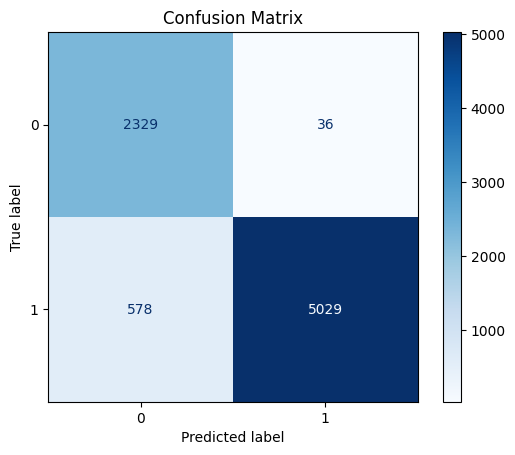


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8012    0.9848    0.8835      2365
           1     0.9929    0.8969    0.9425      5607

    accuracy                         0.9230      7972
   macro avg     0.8970    0.9408    0.9130      7972
weighted avg     0.9360    0.9230    0.9250      7972



In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# ============================
# ✅ Configuration
# ============================
NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# ✅ Load model architecture
# ============================
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CustomDenseNet121, self).__init__()
        base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        self.features = base_model.features
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(base_model.classifier.in_features, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.classifier(x)
        return x

# ============================
# ✅ Initialize model
# ============================
model7 = CustomDenseNet121(num_classes=NUM_CLASSES).to(DEVICE)

# ============================
# ✅ Load the weights
# ============================
model7.load_state_dict(torch.load("best_model7.pth"))
model7.eval()

# ============================
# ✅ Test function
# ============================
def test_model7(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100. * correct / total
    print(f"\n✅ Test Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    # Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

# ============================
# ✅ Test the model
# ============================
print("\n🚀 Testing best model...")
test_model7(model7, test_loader)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn “darkgrid” theme
sns.set_theme(style="darkgrid")

# Now your original plotting code works:
epochs_range = range(1, EPOCHS + 1)

# 🔹 Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses,   label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 🔹 Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, [a * 100 for a in train_accuracies], label='Train Acc')
plt.plot(epochs_range, [a * 100 for a in val_accuracies],   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()